In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

churn_data = pd.read_csv('churn_data.csv')


In [21]:
churn_data.dtypes

CustomerID                       int64
Churn                            int64
Tenure                         float64
PreferredLoginDevice            object
CityTier                         int64
WarehouseToHome                float64
PreferredPaymentMode            object
Gender                          object
HourSpendOnApp                 float64
NumberOfDeviceRegistered         int64
PreferedOrderCat                object
SatisfactionScore                int64
MaritalStatus                   object
NumberOfAddress                  int64
Complain                         int64
OrderAmountHikeFromlastYear    float64
CouponUsed                     float64
OrderCount                     float64
DaySinceLastOrder              float64
CashbackAmount                   int64
dtype: object

In [22]:
churn_data.columns

Index(['CustomerID', 'Churn', 'Tenure', 'PreferredLoginDevice', 'CityTier',
       'WarehouseToHome', 'PreferredPaymentMode', 'Gender', 'HourSpendOnApp',
       'NumberOfDeviceRegistered', 'PreferedOrderCat', 'SatisfactionScore',
       'MaritalStatus', 'NumberOfAddress', 'Complain',
       'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount',
       'DaySinceLastOrder', 'CashbackAmount'],
      dtype='object')

In [23]:
churn_data.drop('PreferedOrderCat', axis=1, inplace=True)

In [24]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

categorical_columns = ['PreferredLoginDevice', 'PreferredPaymentMode', 'Gender', 'MaritalStatus']

label_encoder = LabelEncoder()

for col in categorical_columns:
    if churn_data[col].dtype == 'object':  # Check if the column is of string type
        churn_data[col] = label_encoder.fit_transform(churn_data[col])

churn_data = pd.get_dummies(churn_data, columns=categorical_columns, drop_first=True)

print(churn_data.head())

   CustomerID  Churn  Tenure  CityTier  WarehouseToHome  HourSpendOnApp  \
0       50001      1     4.0         3              6.0             3.0   
1       50002      1     NaN         1              8.0             3.0   
2       50003      1     NaN         1             30.0             2.0   
3       50004      1     0.0         3             15.0             2.0   
4       50005      1     0.0         1             12.0             NaN   

   NumberOfDeviceRegistered  SatisfactionScore  NumberOfAddress  Complain  \
0                         3                  2                9         1   
1                         4                  3                7         1   
2                         4                  3                6         1   
3                         4                  5                8         0   
4                         3                  5                3         0   

   ...  PreferredLoginDevice_2  PreferredPaymentMode_1  \
0  ...                   Fal

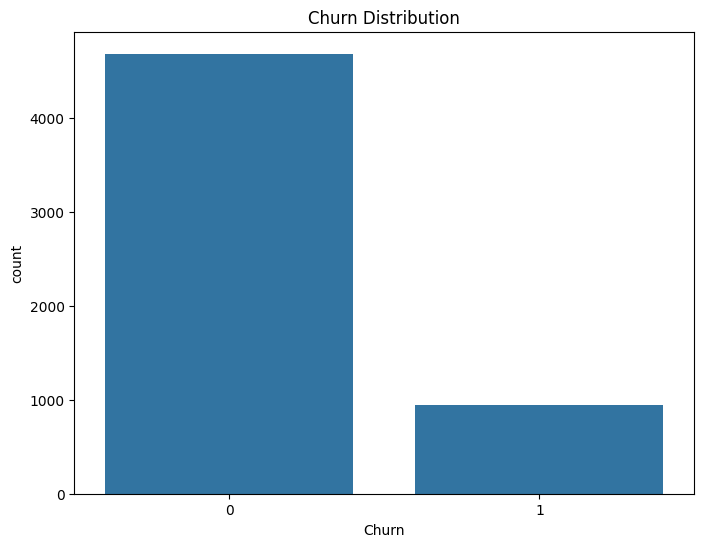

In [25]:
churn_data.fillna(churn_data.mean(), inplace=True)  

plt.figure(figsize=(8,6))
sns.countplot(x='Churn', data=churn_data)
plt.title('Churn Distribution')
plt.show()

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       941
           1       0.99      0.77      0.87       185

    accuracy                           0.96      1126
   macro avg       0.98      0.89      0.92      1126
weighted avg       0.96      0.96      0.96      1126

ROC-AUC:  0.8859551368584313


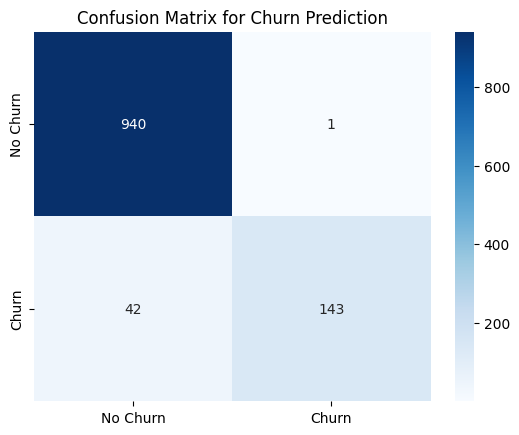

In [26]:
X = churn_data.drop(columns=['Churn'])
y = churn_data['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train)


y_pred = rf_model.predict(X_test_scaled)

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
print(classification_report(y_test, y_pred))
print("ROC-AUC: ", roc_auc_score(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.title('Confusion Matrix for Churn Prediction')
plt.show()

In [27]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

best_model = grid_search.best_estimator_
print("Best Parameters: ", grid_search.best_params_)

y_pred_tuned = best_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred_tuned))

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Parameters:  {'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 300}
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       941
           1       0.99      0.74      0.85       185

    accuracy                           0.96      1126
   macro avg       0.97      0.87      0.91      1126
weighted avg       0.96      0.96      0.95      1126



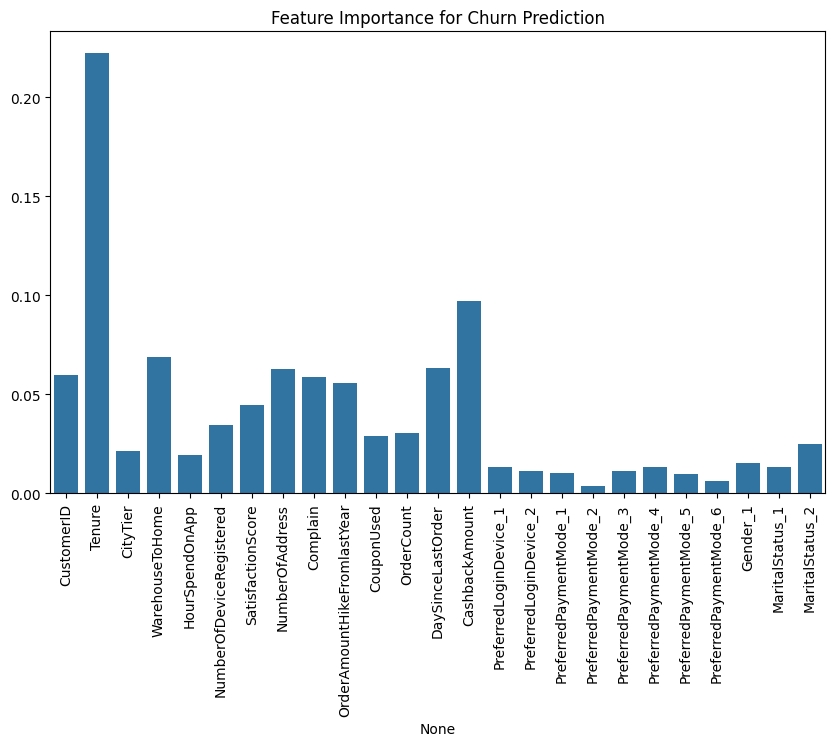

In [28]:
feature_importance = best_model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10,6))
sns.barplot(x=feature_names, y=feature_importance)
plt.title('Feature Importance for Churn Prediction')
plt.xticks(rotation=90)
plt.show()

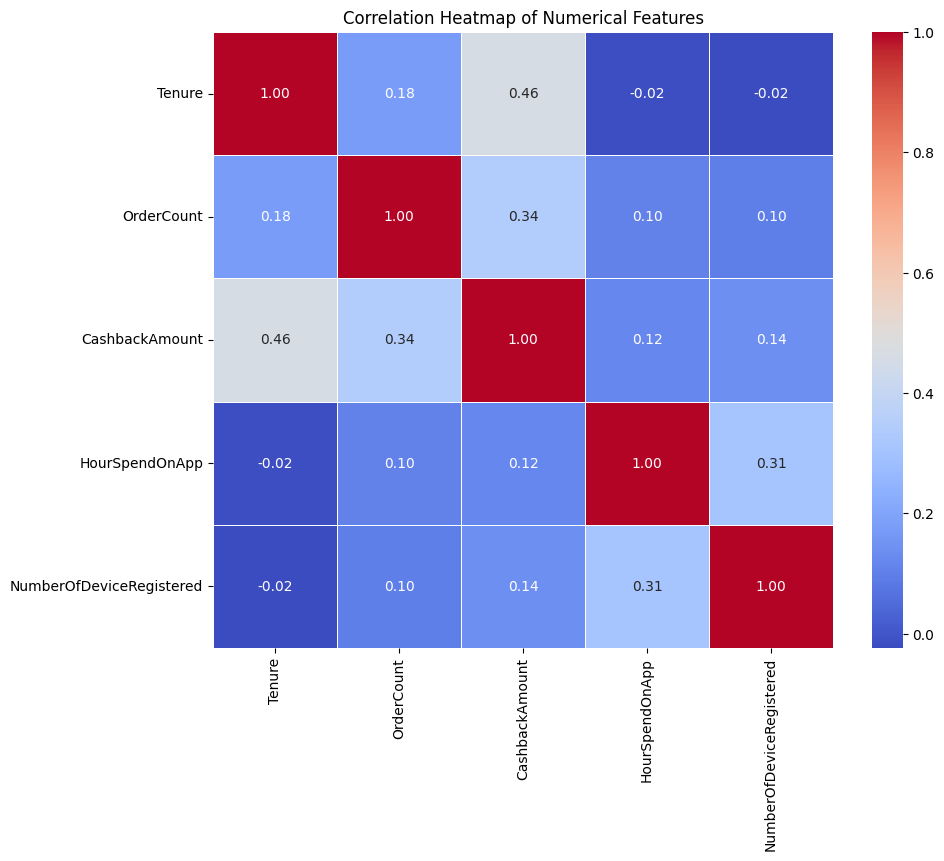

In [29]:
numerical_columns = ['Tenure', 'OrderCount', 'CashbackAmount', 'HourSpendOnApp', 'NumberOfDeviceRegistered']

corr_matrix = churn_data[numerical_columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

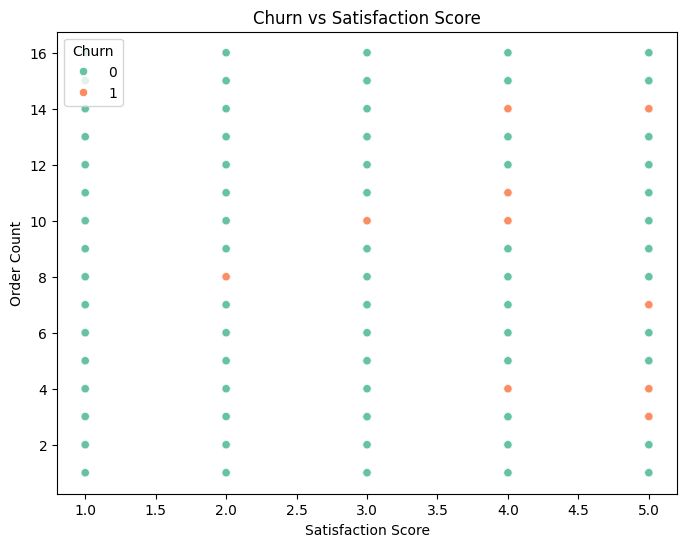

In [30]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='SatisfactionScore', y='OrderCount', hue='Churn', data=churn_data, palette='Set2')
plt.title('Churn vs Satisfaction Score')
plt.xlabel('Satisfaction Score')
plt.ylabel('Order Count')
plt.show()

/var/folders/yr/k2p4vvbj0jx2n4x97x82wvgm0000gn/T/ipykernel_11010/3503266385.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y='Tenure', data=churn_data, palette='Set2')


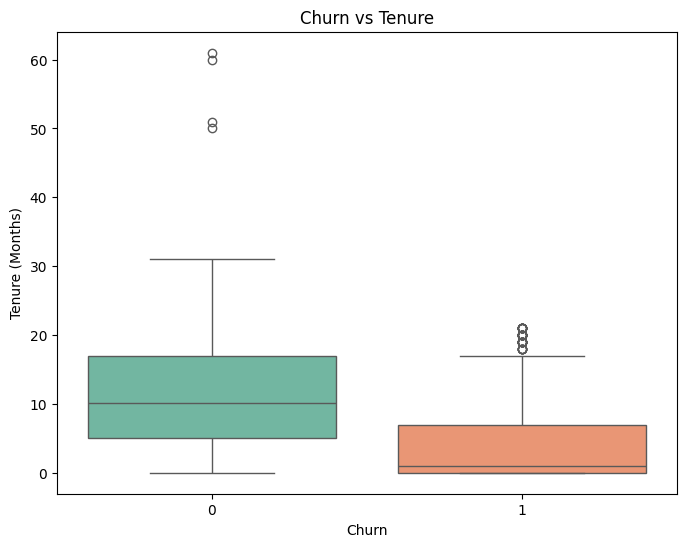

In [31]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Churn', y='Tenure', data=churn_data, palette='Set2')
plt.title('Churn vs Tenure')
plt.xlabel('Churn')
plt.ylabel('Tenure (Months)')
plt.show()